In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("rotskoff_notebook.mplstyle")

In [2]:
DATA_ROOT = ROOT / "results" / "mmresp_hist"
BOOT_DIR  = DATA_ROOT / "bootstrap"

paths = {
    "hip": BOOT_DIR / "hip_stats.tsv",
    "hie": BOOT_DIR / "hie_stats.tsv",
    "hid": BOOT_DIR / "hid_stats.tsv",
}


def load_stats(filepath):
    data = np.genfromtxt(filepath, names=True, dtype=None, encoding=None)
    # Unpack field names in order, we don't care what genfromtxt renamed them to
    atom_field, count_field, mean_field, p2_field, p97_field = data.dtype.names

    return {
        "atoms": data[atom_field],
        "mean":  data[mean_field],
        "p2_5":  data[p2_field],
        "p97_5": data[p97_field],
    }

hip = load_stats(paths["hip"])
hie = load_stats(paths["hie"])
hid = load_stats(paths["hid"])

mm_file = np.load(DATA_ROOT / "charges.npz", allow_pickle=True)
mm_by_mol = mm_file["charges_final_by_mol"][()]


In [3]:
# Reconstruct per-microstate label → MMRESP charge mapping
labels_all = list(mm_file["labels"])  # concatenated labels in save order
cursor = 0
mm_mother = {}  # {"HIP": {atom: charge}, "HIE": {...}, "HID": {...}}

for ms, arr in mm_by_mol.items():
    n = len(arr)
    ms_labels = labels_all[cursor:cursor + n]
    cursor += n
    mm_mother[ms] = {lab: float(q) for lab, q in zip(ms_labels, arr)}

# Quick sanity check (optional)
print(mm_mother["HIP"]["ND1"])  # should be -0.19208009

-0.192080087381108


In [4]:
# Atom name list
hip_atoms_list = [
    'N', 'H', 'CA', 'HA', 'CB', 'HB2', 'HB3', 'CG', 'ND1', 'HD1',
    'CE1', 'HE1', 'NE2', 'HE2', 'CD2', 'HD2', 'C', 'O'
]

# HIP (proton count 2)
hip_charges = [
    -0.3479, 0.2747, -0.1354, 0.1212, -0.0414, 0.0810, 0.0810,
    -0.0012, -0.1513, 0.3866, -0.0170, 0.2681, -0.1718, 0.3911,
    -0.1141, 0.2317, 0.7341, -0.5894
]

# HID (proton count 1)
hid_charges = [
    -0.3479, 0.2747, -0.1354, 0.1212, -0.1110, 0.0402, 0.0402,
    -0.0266, -0.3811, 0.3649, 0.2057, 0.1392, -0.5727, 0.0000,
    0.1292, 0.1147, 0.7341, -0.5894
]

# HIE (proton count 1)
hie_charges = [
    -0.3479, 0.2747, -0.1354, 0.1212, -0.1012, 0.0367, 0.0367,
    0.1868, -0.5432, 0.0000, 0.1635, 0.1435, -0.2795, 0.3339,
    -0.2207, 0.1862, 0.7341, -0.5894
]

# Convert to {atom: charge}
hip_cphmd = dict(zip(hip_atoms_list, hip_charges))
hid_cphmd = dict(zip(hip_atoms_list, hid_charges))
hie_cphmd = dict(zip(hip_atoms_list, hie_charges))

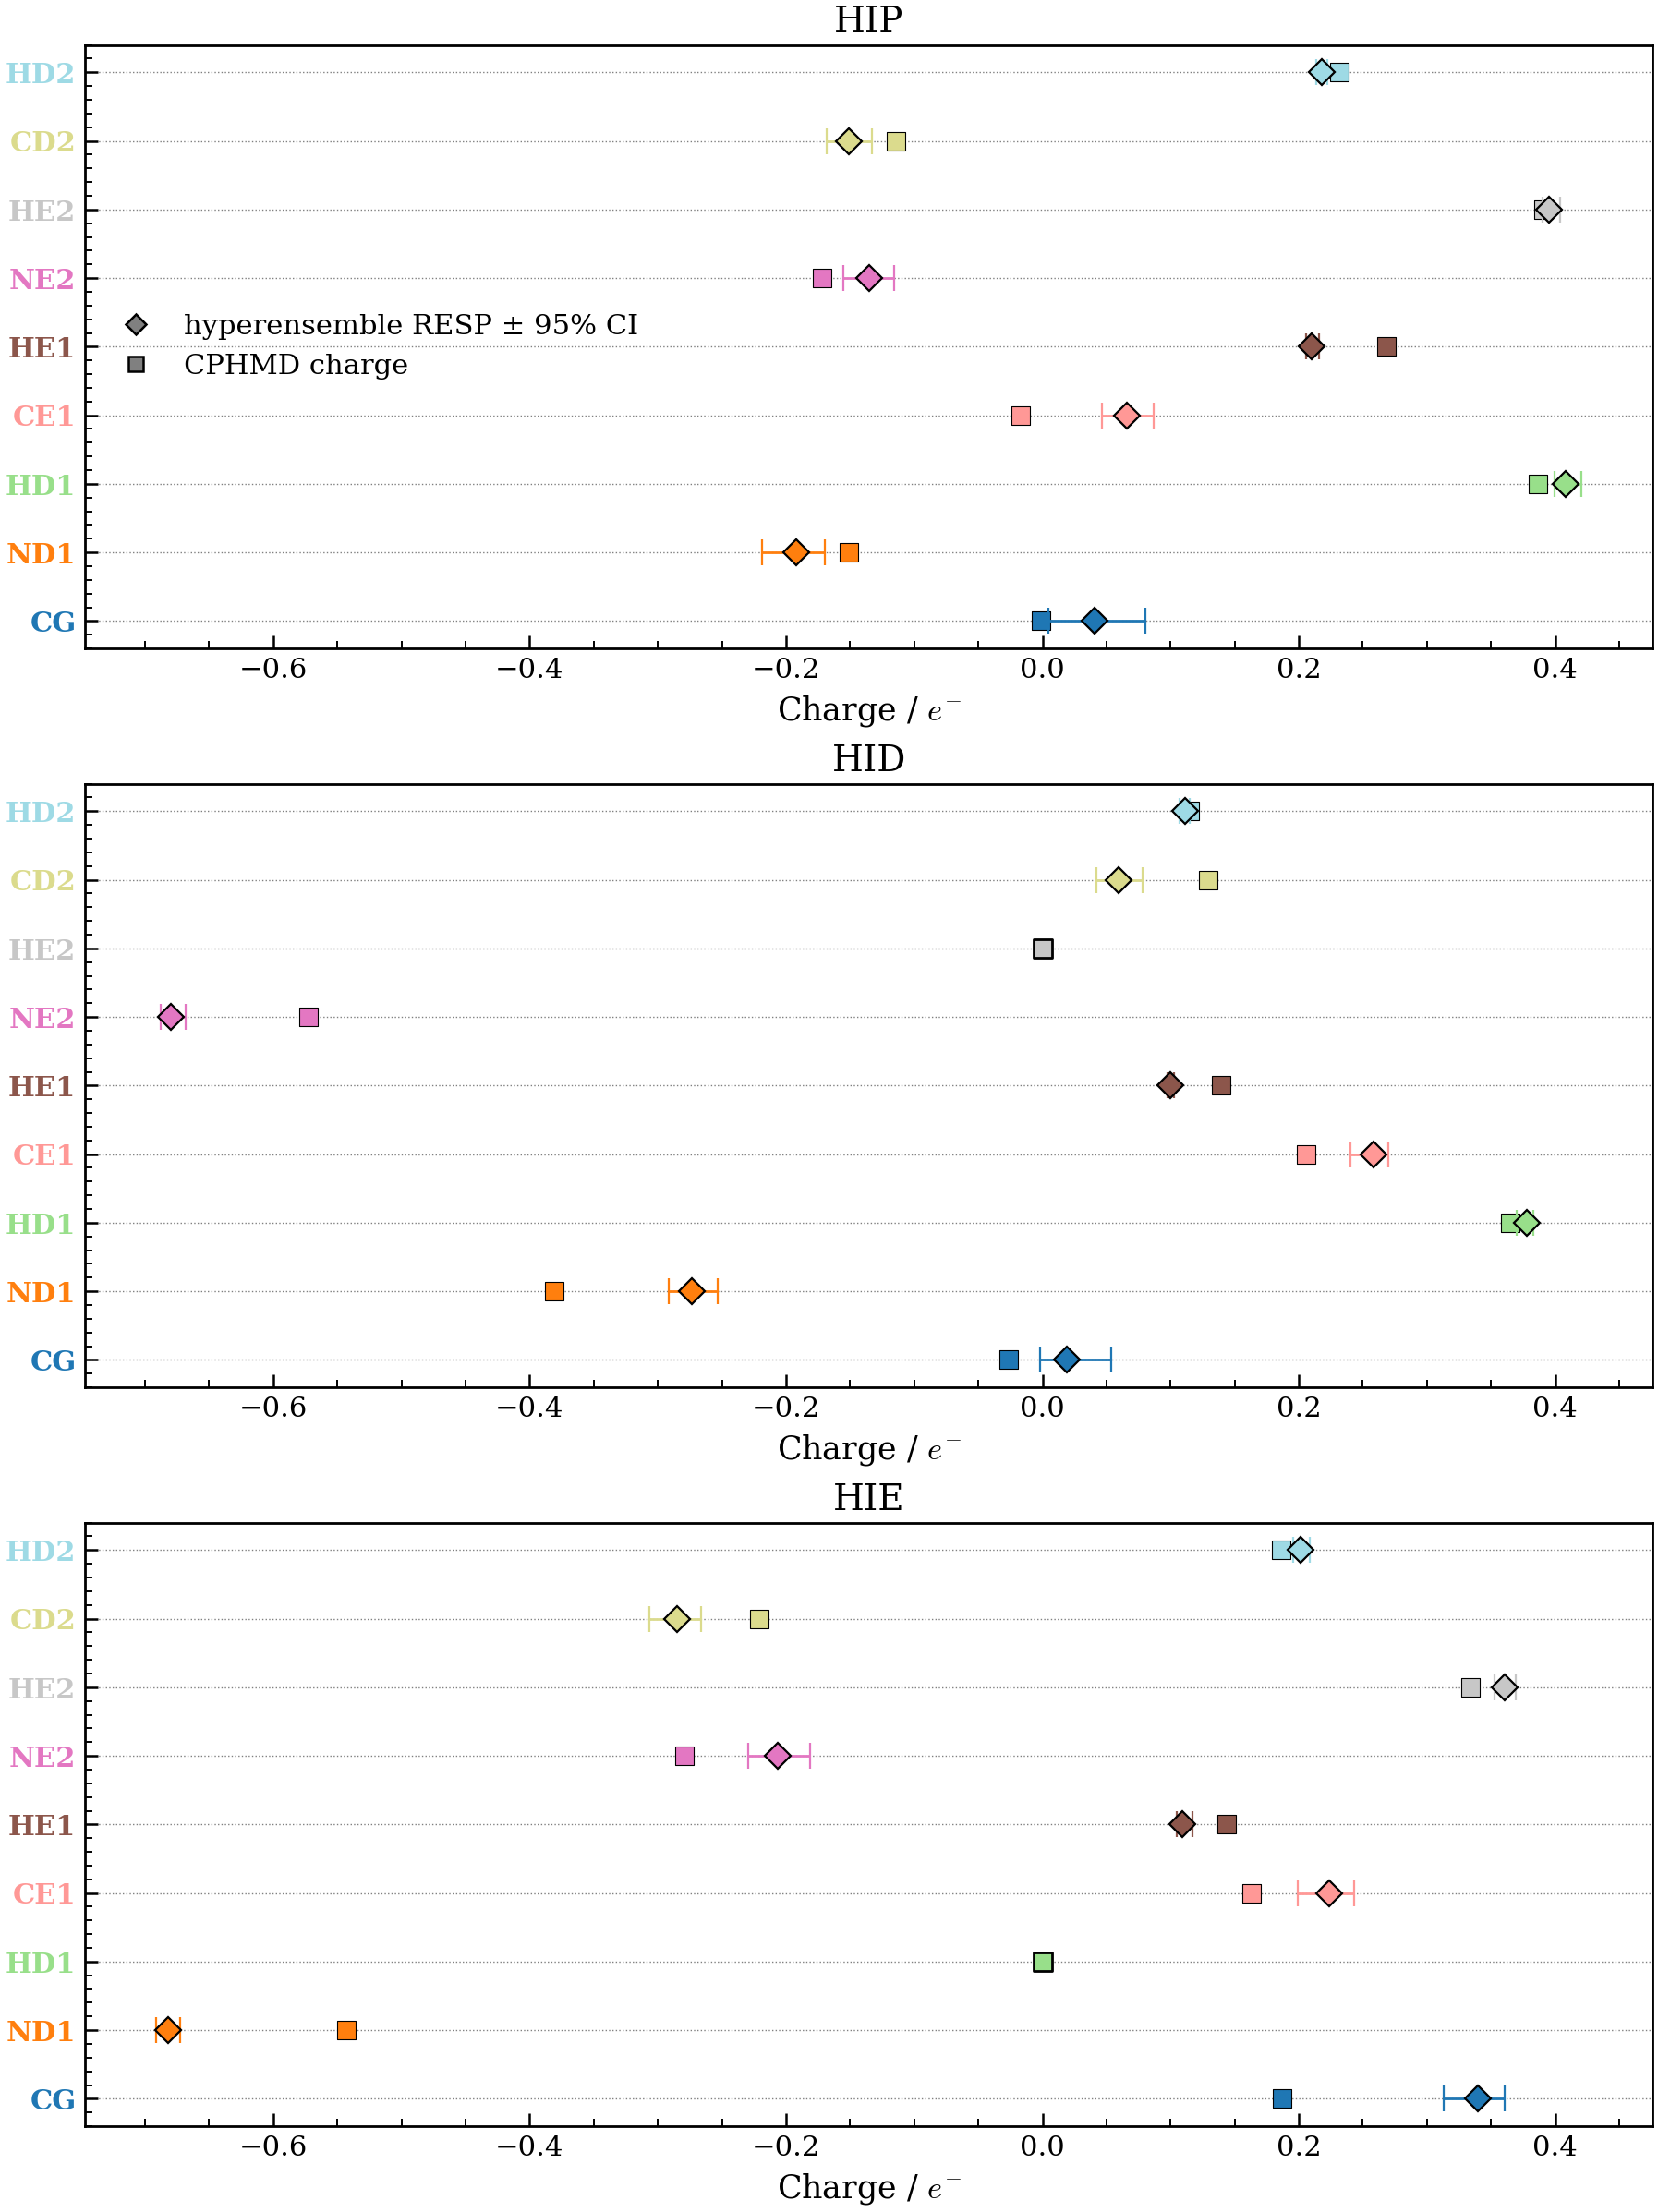

In [5]:
def _to_float_array(arr):
    """Convert mixed string/float array to float, mapping 'NA' -> np.nan."""
    out = []
    for x in arr:
        if isinstance(x, str):
            if x.strip().upper() == "NA":
                out.append(np.nan)
            else:
                out.append(float(x))
        else:
            out.append(float(x))
    return np.array(out, dtype=float)


def plot_state(ax, stats, cphmd_dict, state_name, mm_mother):
    atoms = np.array(stats["atoms"], dtype=str)

    # we need CI limits
    low   = _to_float_array(stats["p2_5"])
    high  = _to_float_array(stats["p97_5"])

    y = np.arange(len(atoms))
    colors = plt.cm.tab20(np.linspace(0, 1, len(atoms)))

    mother_dict = mm_mother[state_name]  # {atom: mother_charge}

    # dotted horizontals at each atom row
    for yi in y:
        ax.axhline(yi, color="gray", ls=":", linewidth=0.5, zorder=0)

    for i, atom in enumerate(atoms):
        lo_ci = low[i]
        hi_ci = high[i]

        color = colors[i]

        # MMRESP mother charge
        mm_val = mother_dict.get(atom, np.nan)
        # CPHMD charge
        c = cphmd_dict.get(atom, np.nan)

        # skip if we don't have CI or mother value
        if np.isnan(mm_val) or np.isnan(lo_ci) or np.isnan(hi_ci):
            # still plot CPHMD square if present
            if not np.isnan(c):
                ax.scatter(
                    c, y[i],
                    marker="s",
                    s=55,
                    color=color,
                    edgecolor="black",
                    linewidth=1.0,
                    zorder=10,
                )
            continue

        # CI around the mother value (diamond)
        left_err  = max(mm_val - lo_ci, 0.0)
        right_err = max(hi_ci - mm_val, 0.0)

        # diamond + horizontal CI bar in one call
        ax.errorbar(
            mm_val, y[i],
            xerr=[[left_err], [right_err]],
            fmt="D",
            markersize=7,
            capsize=5,
            linewidth=1.0,
            color=color,
            ecolor=color,
            markeredgecolor="black",
            markeredgewidth=0.8,
            zorder=6,
        )

        # CPHMD square
        if not np.isnan(c):
            ax.scatter(
                c, y[i],
                marker="s",
                s=55,
                color=color,
                edgecolor="black",
                linewidth=0.4,
                zorder=5,
            )

    # y-axis labels colored by atom
    ax.set_yticks(y)
    ax.set_yticklabels(atoms)
    for tick_lbl, col in zip(ax.get_yticklabels(), colors):
        tick_lbl.set_color(col)
        tick_lbl.set_fontweight("bold")

    ax.set_xlabel(r"Charge / $e^{-}$")
    ax.set_title(state_name)
    ax.grid(False)


# ----------- FIGURE --------------

fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

plot_state(axes[0], hip, hip_cphmd, "HIP", mm_mother)
plot_state(axes[1], hid, hid_cphmd, "HID", mm_mother)
plot_state(axes[2], hie, hie_cphmd, "HIE", mm_mother)

# remove x tick labels on upper two panels
axes[0].tick_params(labelbottom=True)
axes[1].tick_params(labelbottom=True)

# legend: diamond = MMRESP+CI, square = CPHMD
handles = [
    plt.Line2D([0], [0], marker="D", linestyle="none", color="gray",
               markeredgecolor="black", label="hyperensemble RESP ± 95% CI"),
    plt.Line2D([0], [0], marker="s", linestyle="none", color="gray",
               markeredgecolor="black", label="CPHMD charge"),
]
axes[0].legend(handles=handles, loc="best", frameon=False)

#plt.tight_layout()
plt.show()